In [159]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
import plotly.graph_objects as go
from PIL import Image
import base64
import concurrent.futures



### Creating grey scaled floorplan

In [50]:

'''
# Load the color floor plan image
image = cv2.imread('floorplan_images/L_6C.jpg')  

# Convert the color image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Save the grayscale image to a file
cv2.imwrite('L6C_grayscale_image.jpg', gray_image) 
'''



"\n# Load the color floor plan image\nimage = cv2.imread('floorplan_images/L_6C.jpg')  \n\n# Convert the color image to grayscale\ngray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)\n\n# Save the grayscale image to a file\ncv2.imwrite('L6C_grayscale_image.jpg', gray_image) \n"

### compressing the image

In [145]:
from PIL import Image
input_path = '/Users/yg/Downloads/dsa3101-2310-04-library/floorplan_images/L3_grayscale_image.jpg'
output_path = '/Users/yg/Downloads/dsa3101-2310-04-library/floorplan_images/L3_grayscale_downsized.jpg'
def resize_image(input_path, output_path, new_size):
    original_image = Image.open(input_path)
    resized_image = original_image.resize(new_size)
    resized_image.save(output_path)

# Example usage
resize_image(input_path, output_path, (1500, 700))


### loading output csv

In [51]:
csv_file_path = '/Users/yg/Downloads/dsa3101-2310-04-library/datasets/model_output.csv'

df = pd.read_csv(csv_file_path)


### Defining function to store seat types occupancy

In [160]:
def form_seat_types_occupancy(df, level,time,week,day):
    filtered_df = df[(df['level'] == level) & (df['hour'] == time) & (df["week"] == week) &(df["day"] == day)]
    seat_type = {}
    for i in range(filtered_df.shape[0]):
        seat = filtered_df.iloc[i]['seat_type']
        number = filtered_df.iloc[i]['occupancy']
        seat_type[seat] = number
    return seat_type


### Predefined inputs

In [193]:
images_path = {'3': "floorplan_images/L3_grayscale_downsized.jpg",
               '4':"floorplan_images/L4_grayscale_downsized.jpg",
               '5': 'floorplan_images/L5_grayscale_downsized.jpg',
               '6':"floorplan_images/L6_grayscale_downsized.jpg",
               '6Chinese':"floorplan_images/L6C_grayscale_image.jpg"}

actual_seat_count = {'3':{'Discussion.Cubicles':56,
                            'Soft.seats':132,
                            'Moveable.seats':156},
                       '4':{'Soft.seats':268,
                             'Sofa':32},
                       '5':{'Windowed.Seats':97,
                             'X4.man.tables':220,
                             'X8.man.tables':160},
                        '6Chinese':{'Diagonal.Seats':72,
                             'Cubicle.seats':52,
                             'Windowed.Seats':36},
                        '6C':{'Diagonal.Seats':92,
                                    'Cubicle.seats':155,
                                    'Windowed.Seats':136}}

regions_coordinates = {'3':{'Discussion.Cubicles':[[1137,1409,509,566],[1088,1439,114,168]],
                            'Soft.seats':[[467,933,41,66],[521,929,143,266],[1184,1431,632,662],[1185,1431,41,72]],
                            'Moveable.seats':[[1149,1406,233,464]]},
                       '4':{'Soft.seats':[[309,429,149,252],[579,698,268,378],[855,1004,171,200],[1224,1340,363,557],[1190,1353,623,636]],
                             'Sofa':[[278,462,300,350], [768, 1052,299,348]]},
                       '5':{'Windowed.Seats':[[12 ,323,9,29],[9,36,29,287],[38,323,264,285],[432,1194,171,197],[11,506,620,648],[507,701,525,549],[1244,1464,620,645],[1464,1499,198,623],[1242,1499,171,194]],
                             'X4.man.tables':[[80,281,42,71],[59,266,468,497],[344,413,80,158],[380,449,471,495],[569,638,470,495],[1083,1152,228,435]],
                             'X8.man.tables':[[528,1029,224,260],[348,482,557,580]]},
                        '6':{'Diagonal.Seats':[[390,485,147,209],[590,687,147,209],[786,882,147,209],[971,1067,147,209],[1155,1250,147,209]],
                             'Cubicle.seats':[[92,327,129,216], [387,1229,93,122],[1007,1239,288,578]],
                             'Windowed.Seats':[[95,1427,27,68],[1403,1467,114,599] ,[1124,1425,635,678]]},
                        '6Chinese':{'Diagonal.Seats':[[281,372,285,339],[464,555,285,339],[638,729,285,339],[819,909,285,339],[992,1082,285,339]],
                                    'Cubicle.seats':[[324,1217,390,419]],
                                    'Windowed.Seats':[[96,138,239,407],[1377,1422,320,620],[291,1296,632,659]]}}
seat_names = {"Discussion.Cubicles": "Discussion Cubicles", "Soft.seats" : "Soft Seats", "Moveable.seats": "Moveable Seats",
                  "Sofa":"Sofa","Windowed.Seats":"Windowed Seats","X4.man.tables":"4 Man Tables","X8.man.tables":"8 Man Tables",
                  "Diagonal.Seats": "Diagonal Seats","Cubicle.seats":"Cubicle Seats"}


### Inputs from home page

In [210]:
level = '3'
week = '9'
day = 3
time = 14
region = regions_coordinates[level]
image_path = '/Users/yg/Downloads/dsa3101-2310-04-library/floorplan_images/L3_grayscale_downsized.jpg'
students = form_seat_types_occupancy(df, level,time,week,day)
print(students)

{'Discussion.Cubicles': 33, 'Soft.seats': 32, 'Moveable.seats': 16}


## Plotly version (faster)


### Without color bar and hover

In [175]:
import plotly.graph_objects as go
import numpy as np
from PIL import Image
import base64
import concurrent.futures
import cv2

def compute_contour_data(seat_type, coordinates_list, students, contour_data):
    for x1, x2, y1, y2 in coordinates_list:
        student_count = students.get(seat_type, 0)
        # Update the corresponding region in the contour data
        contour_data[y1:y2 + 1, x1:x2 + 1] = student_count

def generate_floorplan_contour_plotly(image_path, region, students):
    # Load the floorplan image and convert to data URI
    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
        data_uri = f"data:image/png;base64,{encoded_image}"

    color_list = ['#00FFFF', '#00FF00', '#7FFF00', '#FFFF00', '#FFA500', '#FF6347', '#FF4500', '#FF0000']
    # Load the floorplan image for other processing
    image = cv2.imread(image_path)
    x_range = np.arange(image.shape[1])
    y_range = np.arange(image.shape[0])
    xx, yy = np.meshgrid(x_range, y_range)

    # Create an array for contour data
    contour_data = np.zeros_like(xx, dtype=np.float32)

    # Parallelize the computation of contour_data
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(compute_contour_data, seat_type, coordinates_list, students, contour_data)
                   for seat_type, coordinates_list in region.items()]
        concurrent.futures.wait(futures)

    # Apply Gaussian blur to the contour data with a smaller kernel
    contour_data = cv2.blur(contour_data, (32.5, 32.5), cv2.BORDER_DEFAULT)
    print(contour_data.shape)
    print(image.shape)

    # Invert the y-axis data
    contour_data = np.flipud(contour_data)

    # Create the contour plot using Plotly
    fig = go.Figure()

    # Add filled contour plot using the custom colormap
    fig.add_trace(go.Heatmap(z=contour_data, colorscale=color_list, showscale=False, zmin=0, zmax=max(students.values()), opacity=0.8,
                             hoverinfo="text+name", text=[[f"Seat Type: {seat_type}<br>Student Count: {students[seat_type]}" 
                                                           for seat_type in region.keys()] for row in contour_data]))

    # Add floorplan image as background
    fig.add_layout_image(
        source=data_uri,
        x=0,
        y=1,  # Adjust the y value to position the floorplan under the plot
        xref="paper",
        yref="paper",  # Use 'paper' as the reference for y-axis
        sizex=1,  # Set sizex to 1 to cover the entire x-axis
        sizey=1,  # Set sizey to 1 to cover the entire y-axis
        sizing="stretch",  # Ensure the floorplan covers the entire plot
        opacity=1,
        layer="below"  # Set the layer to "below" to place it under the plot
    )

    # Customize layout
    fig.update_layout(
        width=image.shape[1],
        height=image.shape[0],
        # title_text=f'Level {level}',
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        coloraxis_colorbar=dict(
            title='Student Count',
            tickvals=np.linspace(0, max(students.values()), len(color_list)).tolist(),
            ticktext=np.linspace(0, max(students.values()), len(color_list)).astype(int).tolist(),
        ),
        template='plotly_white'
    )

    # Save the plot to an HTML file
    fig.write_html(f'Level{level}.html')

# Example usage
generate_floorplan_contour_plotly(image_path, region, students)


(700, 1500)
(700, 1500, 3)


### Final version with colorbar and labels 

In [ ]:
def compute_contour_data(seat_type, coordinates_list, students, contour_data, text_data):
    for x1, x2, y1, y2 in coordinates_list:
        student_count = students.get(seat_type, 0)
        # Update the corresponding region in the contour data
        contour_data[y1:y2 + 1, x1:x2 + 1] = student_count
        # Update the text data for hover information
        occupancy_rate = round((student_count/(actual_seat_count[level][seat_type]))*100,2)
        seat = seat_names[seat_type]
        #inverting y coordinates
        inverted_y1, inverted_y2 = contour_data.shape[0] - y2 - 1, contour_data.shape[0] - y1 - 1
        text_data[inverted_y1:inverted_y2 + 1, x1:x2 + 1] = f"Seat Type: {seat}<br>Student Count: {student_count}<br>Occupancy Rate: {occupancy_rate}%"

def generate_floorplan_contour_plotly(image_path, region, students):
    # Load the floorplan image and convert to data URI
    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
        data_uri = f"data:image/png;base64,{encoded_image}"

    color_list = ['#00FFFF', '#00FF00', '#7FFF00', '#FFFF00', '#FFA500', '#FF6347', '#FF4500', '#FF0000']
    # Load the floorplan image for other processing
    image = cv2.imread(image_path)
    x_range = np.arange(image.shape[1])
    y_range = np.arange(image.shape[0])
    xx, yy = np.meshgrid(x_range, y_range)

    # Create arrays for contour data and text data
    contour_data = np.zeros_like(xx, dtype=np.float32)
    text_data = np.empty_like(xx, dtype=object)

    # Parallelize the computation of contour_data and text_data
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(compute_contour_data, seat_type, coordinates_list, students, contour_data, text_data)
                   for seat_type, coordinates_list in region.items()]
        concurrent.futures.wait(futures)

    # Apply Gaussian blur to the contour data with a smaller kernel
    contour_data = cv2.blur(contour_data, (33, 33), cv2.BORDER_DEFAULT)

    # Invert the y-axis data
    contour_data = np.flipud(contour_data)

    # Create the contour plot using Plotly
    fig = go.Figure()

    # Add filled contour plot using the custom colormap
    heatmap_trace = go.Heatmap(z=contour_data, colorscale=color_list, showscale=True, zmin=0, zmax=max(students.values()), opacity=0.8,
                               hoverinfo="text", text=text_data)

    # Add floorplan image as background
    fig.add_layout_image(
        source=data_uri,
        x=0,
        y=1,  # Adjust the y value to position the floorplan under the plot
        xref="paper",
        yref="paper",  # Use 'paper' as the reference for y-axis
        sizex=1,  # Set sizex to 1 to cover the entire x-axis
        sizey=1,  # Set sizey to 1 to cover the entire y-axis
        sizing="stretch",  # Ensure the floorplan covers the entire plot
        opacity=1,
        layer="below"  # Set the layer to "below" to place it under the plot
    )

    # Add colorbar trace below the plot
    colorbar_trace = go.Heatmap(z=[[0, max(students.values())]], colorscale=color_list, showscale=False, zmin=0, zmax=max(students.values()),
                                hoverinfo="skip", colorbar=dict(
                                    orientation="h",
                                    title='Student Count',
                                    tickvals=np.linspace(0, max(students.values()), len(color_list)).tolist(),
                                    ticktext=np.linspace(0, max(students.values()), len(color_list)).astype(int).tolist(),
                                ))

    # Update layout
    fig.update_layout(
        width=image.shape[1],
        height=image.shape[0],
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        coloraxis_colorbar=dict(
            tickvals=np.linspace(0, max(students.values()), len(color_list)).tolist(),
            ticktext=np.linspace(0, max(students.values()), len(color_list)).astype(int).tolist(),
        ),
        template='plotly_white',
    )

    # Add traces to the figure
    fig.add_trace(heatmap_trace)
    fig.add_trace(colorbar_trace)

    # Save the plot to an HTML file
    return fig


# Example usage

generate_floorplan_contour_plotly(image_path, region, students)

In [180]:
import plotly.graph_objects as go
import numpy as np
from PIL import Image
import base64
import concurrent.futures
import cv2

def compute_contour_data(seat_type, coordinates_list, students, contour_data):
    for x1, x2, y1, y2 in coordinates_list:
        student_count = students.get(seat_type, 0)
        # Update the corresponding region in the contour data
        contour_data[y1:y2 + 1, x1:x2 + 1] = student_count

def generate_floorplan_contour_plotly(image_path, region, students):
    # Load the floorplan image and convert to data URI
    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
        data_uri = f"data:image/png;base64,{encoded_image}"

    color_list = ['#00FFFF', '#00FF00', '#7FFF00', '#FFFF00', '#FFA500', '#FF6347', '#FF4500', '#FF0000']
    # Load the floorplan image for other processing
    image = cv2.imread(image_path)
    x_range = np.arange(image.shape[1])
    y_range = np.arange(image.shape[0])
    xx, yy = np.meshgrid(x_range, y_range)

    # Create an array for contour data
    contour_data = np.zeros_like(xx, dtype=np.float32)

    # Parallelize the computation of contour_data
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(compute_contour_data, seat_type, coordinates_list, students, contour_data)
                   for seat_type, coordinates_list in region.items()]
        concurrent.futures.wait(futures)

    # Apply Gaussian blur to the contour data with a smaller kernel
    contour_data = cv2.blur(contour_data, (33, 33), cv2.BORDER_DEFAULT)

    # Invert the y-axis data
    contour_data = np.flipud(contour_data)

    # Create the contour plot using Plotly
    fig = go.Figure()

    # Add filled contour plot using the custom colormap
    heatmap_trace = go.Heatmap(z=contour_data, colorscale=color_list, showscale=False, zmin=0, zmax=max(students.values()), opacity=0.8,
                               hoverinfo="text", text=[[f"Seat Type: {seat_type}<br>Student Count: {students[seat_type]}" 
                                                         for seat_type in region.keys()] for row in contour_data])

    # Add floorplan image as background
    fig.add_layout_image(
        source=data_uri,
        x=0,
        y=1,  # Adjust the y value to position the floorplan under the plot
        xref="paper",
        yref="paper",  # Use 'paper' as the reference for y-axis
        sizex=1,  # Set sizex to 1 to cover the entire x-axis
        sizey=1,  # Set sizey to 1 to cover the entire y-axis
        sizing="stretch",  # Ensure the floorplan covers the entire plot
        opacity=1,
        layer="below"  # Set the layer to "below" to place it under the plot
    )

    # Add colorbar trace
    colorbar_trace = go.Heatmap(z=[[0, max(students.values())]], colorscale=color_list, showscale=True, zmin=0, zmax=max(students.values()),
                                hoverinfo="skip", colorbar=dict(
                                    orientation="h",
                                    title='Student Count',
                                    tickvals=np.linspace(0, max(students.values()), len(color_list)).tolist(),
                                    ticktext=np.linspace(0, max(students.values()), len(color_list)).astype(int).tolist(),
                                ))

    # Update layout
    fig.update_layout(
        width=image.shape[1],
        height=image.shape[0],
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        coloraxis_colorbar=dict(
            title='Number of Students', 
            titleside='right'
            tickvals=np.linspace(0, max(students.values()), len(color_list)).tolist(),
            ticktext=np.linspace(0, max(students.values()), len(color_list)).astype(int).tolist(),
        ),
        template='plotly_white',
    )

    # Add traces to the figure
    fig.add_trace(heatmap_trace)
    fig.add_trace(colorbar_trace)

    # Save the plot to an HTML file
    fig.write_html(f'Level5_try.html')


generate_floorplan_contour_plotly(image_path, region, students)


## original matplotlib func

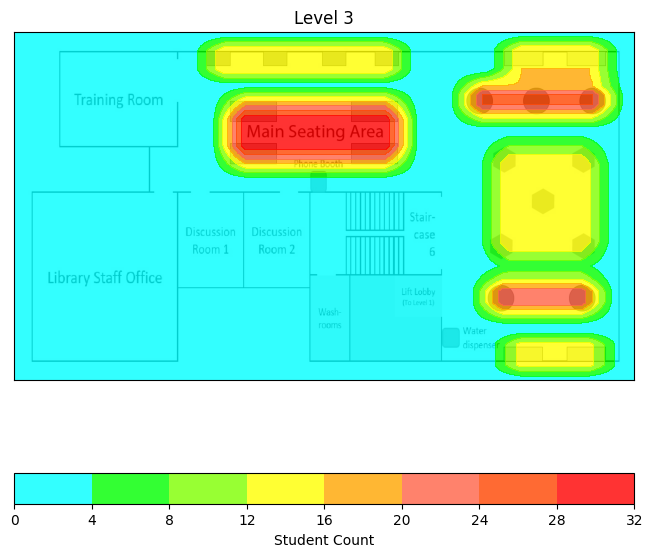

In [93]:


import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

level = '3'
week = '9'
day = 3
time = 14

region = regions_coordinates[level]
students = form_seat_types_occupancy(df, level, time, week, day)
image_path = '/Users/yg/Downloads/dsa3101-2310-04-library/floorplan_images/L3_grayscale_image.jpg'
image = cv2.imread(image_path)

# Define a custom colormap with colors corresponding to student counts
# Adjust the color_list to your preferred colors
color_list = ['#00FFFF', '#00FF00', '#7FFF00', '#FFFF00', '#FFA500', '#FF6347', '#FF4500', '#FF0000']

  # Example colors
cmap = LinearSegmentedColormap.from_list('custom_cmap', color_list, N=len(color_list))

def generate_floorplan_contour(image, region, students):
    x_range = np.arange(image.shape[1])
    y_range = np.arange(image.shape[0])
    xx, yy = np.meshgrid(x_range, y_range)
    
    # Create an array for contour data
    contour_data = np.zeros_like(xx, dtype=np.float32)
    
    for seat_type, coordinates_list in region.items():
        for x1, x2, y1, y2 in coordinates_list:
            student_count = students.get(seat_type, 0)
            # Update the corresponding region in the contour data
            contour_data[y1:y2 + 1, x1:x2 + 1] = student_count
    
    # Apply Gaussian blur to the contour data
    contour_data = cv2.blur(contour_data, (80, 80), cv2.BORDER_DEFAULT)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image)

    # Create the contour plot using the custom colormap
    contours = ax.contourf(xx, yy, contour_data, cmap=cmap, levels=len(color_list), alpha=0.8)

    # Create a color bar
    cbar = plt.colorbar(contours, ax=ax, orientation='horizontal')
    cbar.set_label('Student Count')

    # Remove axis labels
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title('Level 3')
    plt.savefig('Level3_final.png')
    plt.show()

generate_floorplan_contour(image, region, students)

 


